In [1]:
#DIR_DataSet
https://drive.google.com/drive/folders/1bQMD5W0OvGge6MwximMdWk64-hR2sKRQ?usp=sharing

SyntaxError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageOps
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
from sklearn.datasets import fetch_openml
from torch.utils.data import DataLoader
%matplotlib inline
from pycocotools.coco import COCO
import pylab

pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [15]:
data_root = '/content/drive/MyDrive/Car/'
import os
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['clean', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 169/169 [00:00<00:00, 243.76it/s]


In [16]:
!ls train

clean  dirty


In [17]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
len(train_dataloader), len(train_dataset)

(32, 256)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


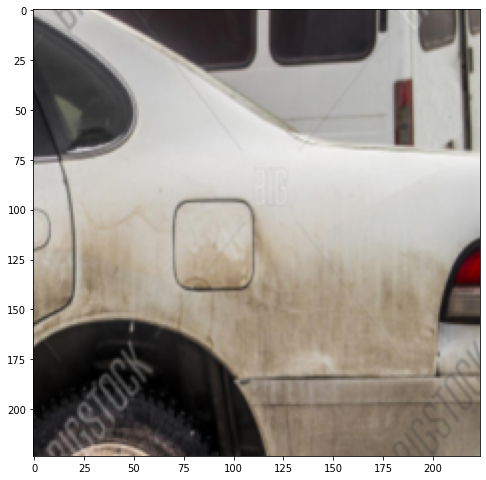

In [21]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


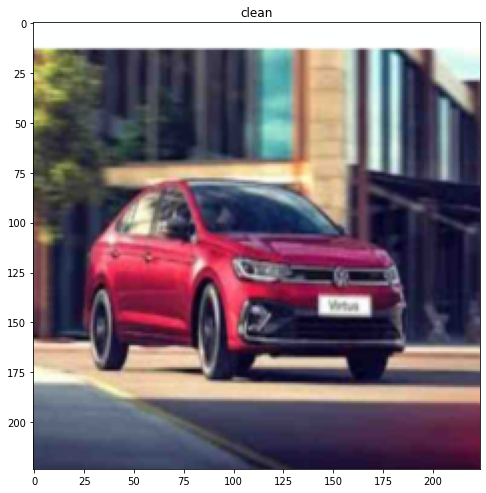

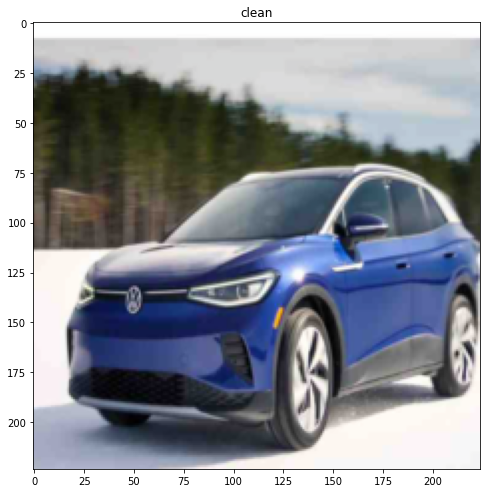

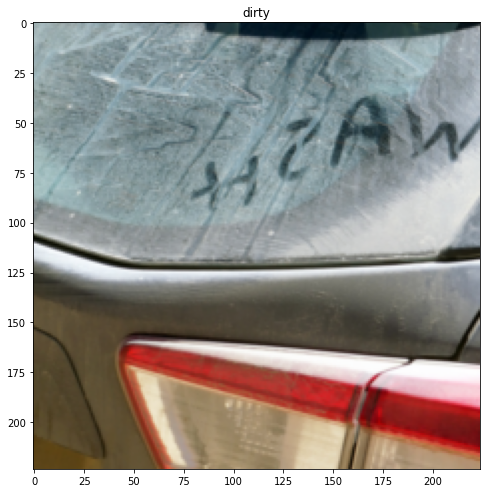

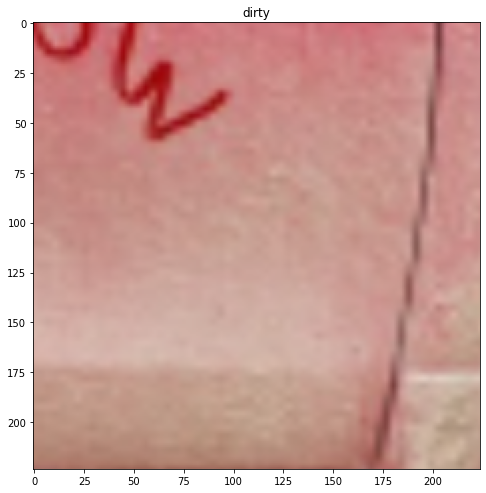

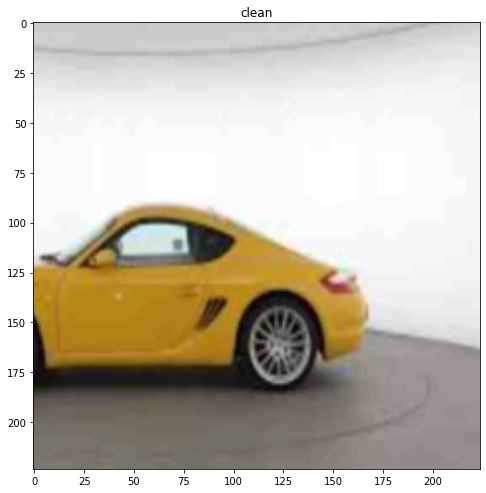

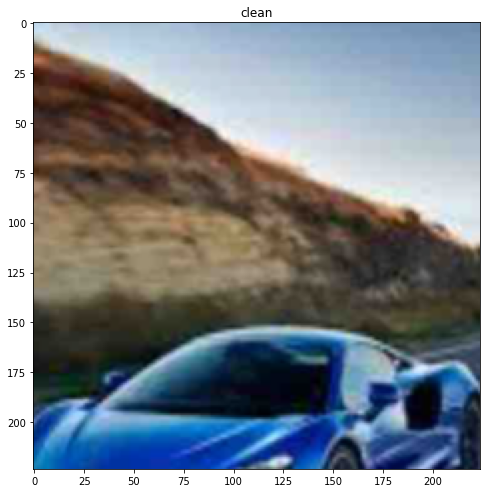

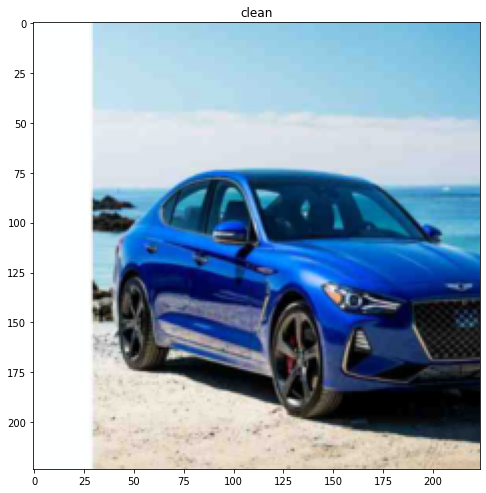

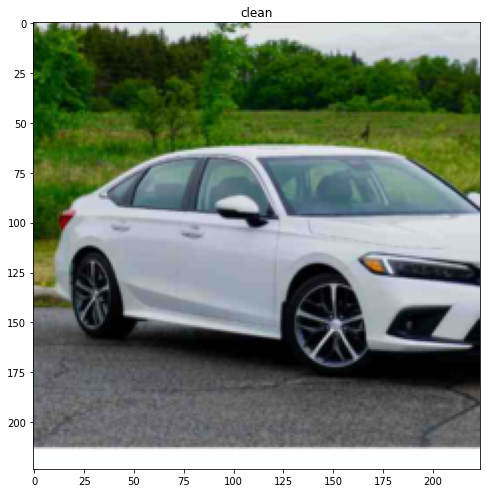

In [20]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [22]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [23]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slow

train Loss: 0.6304 Acc: 0.6055



100%|██████████| 7/7 [00:01<00:00,  5.96it/s]

val Loss: 0.3894 Acc: 0.8393
Epoch 1/9:



100%|██████████| 32/32 [00:03<00:00,  9.02it/s]

train Loss: 0.3888 Acc: 0.8320



100%|██████████| 7/7 [00:01<00:00,  5.94it/s]

val Loss: 0.3788 Acc: 0.8286
Epoch 2/9:



100%|██████████| 32/32 [00:03<00:00,  8.97it/s]

train Loss: 0.4022 Acc: 0.7930



100%|██████████| 7/7 [00:01<00:00,  4.96it/s]

val Loss: 0.2804 Acc: 0.9286
Epoch 3/9:



100%|██████████| 32/32 [00:04<00:00,  8.00it/s]

train Loss: 0.3407 Acc: 0.8633



100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

val Loss: 0.3527 Acc: 0.8643
Epoch 4/9:



100%|██████████| 32/32 [00:03<00:00,  8.81it/s]

train Loss: 0.2632 Acc: 0.9141



100%|██████████| 7/7 [00:01<00:00,  5.58it/s]

val Loss: 0.3775 Acc: 0.8464
Epoch 5/9:



100%|██████████| 32/32 [00:05<00:00,  6.25it/s]

train Loss: 0.3486 Acc: 0.8242



100%|██████████| 7/7 [00:01<00:00,  6.09it/s]

val Loss: 0.2519 Acc: 0.9286
Epoch 6/9:



100%|██████████| 32/32 [00:03<00:00,  8.91it/s]

train Loss: 0.3052 Acc: 0.8750



100%|██████████| 7/7 [00:01<00:00,  5.91it/s]

val Loss: 0.2448 Acc: 0.9286
Epoch 7/9:



100%|██████████| 32/32 [00:03<00:00,  8.88it/s]

train Loss: 0.2634 Acc: 0.8984



100%|██████████| 7/7 [00:01<00:00,  5.88it/s]

val Loss: 0.2602 Acc: 0.8821
Epoch 8/9:



100%|██████████| 32/32 [00:03<00:00,  8.87it/s]

train Loss: 0.1921 Acc: 0.9336



100%|██████████| 7/7 [00:01<00:00,  6.03it/s]

val Loss: 0.2875 Acc: 0.8821
Epoch 9/9:



100%|██████████| 32/32 [00:03<00:00,  9.00it/s]

train Loss: 0.2373 Acc: 0.8984



100%|██████████| 7/7 [00:01<00:00,  5.92it/s]

val Loss: 0.2466 Acc: 0.9286


In [55]:
test_dir = 'test1'
shutil.copytree(os.path.join(data_root, 'test1'), os.path.join(test_dir, 'unknown'))

'test1/unknown'

In [56]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/content/test1', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [57]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 8
    Root location: /content/test1
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [58]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


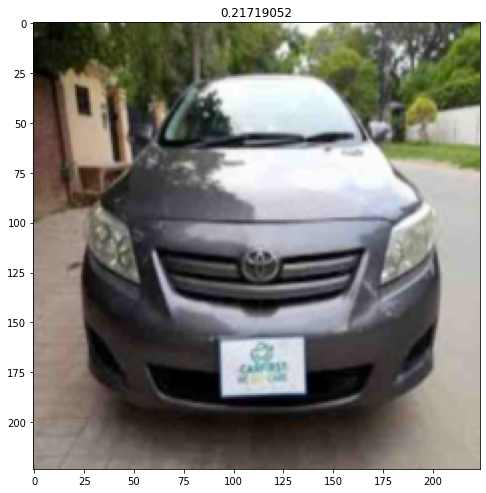

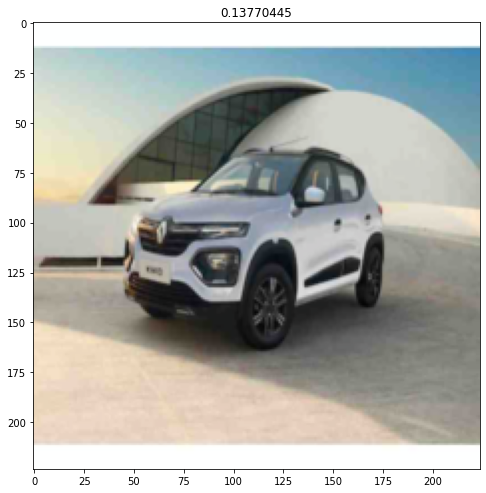

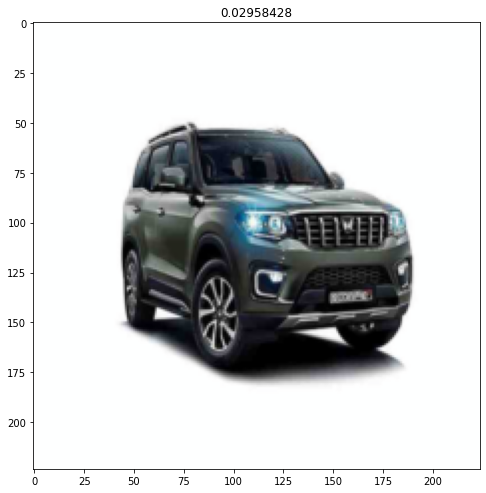

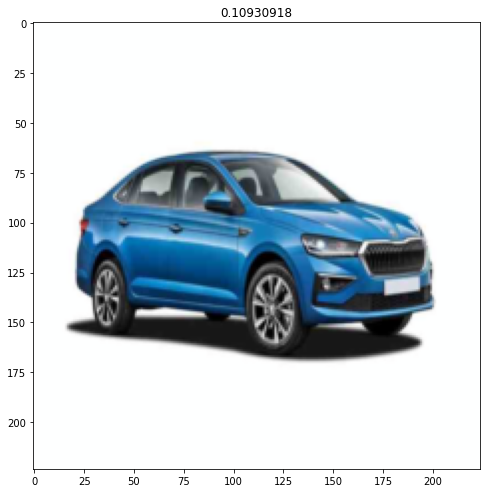

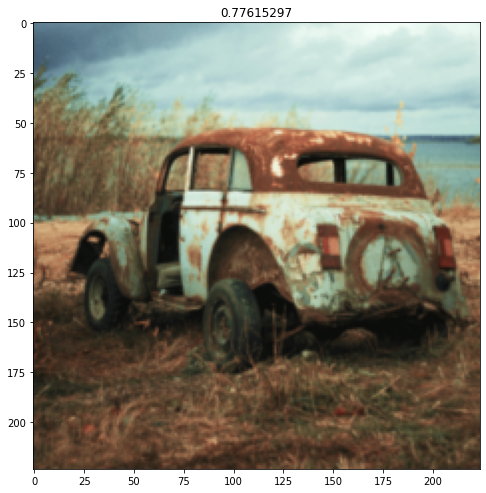

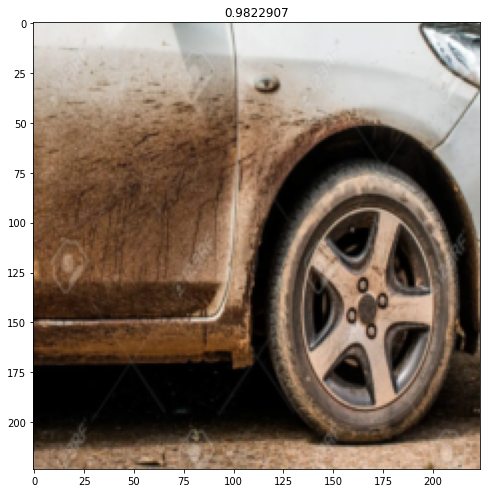

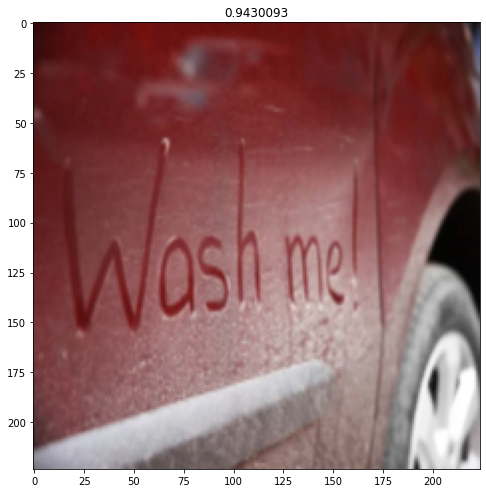

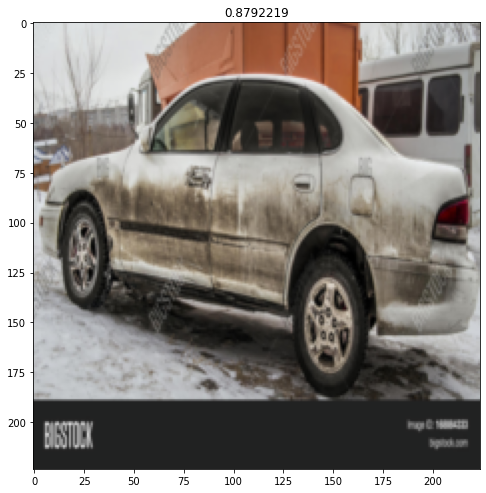

In [63]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [64]:
import pandas as pd
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [65]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/test/unknown', '')
submission_df['id'] = submission_df['id'].str.replace('.png', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


label
id                                             
/content/test1/unknown/clean (137).jpg  cleaned
/content/test1/unknown/clean (138).jpg  cleaned
/content/test1/unknown/clean (139).jpg  cleaned
/content/test1/unknown/clean (140).jpg  cleaned
/content/test1/unknown/dirty (101)        dirty
/content/test1/unknown/dirty (102)        dirty
/content/test1/unknown/dirty (103)        dirty
/content/test1/unknown/dirty (104)        dirty